In [ ]:
import pandas as pd
from datetime import timedelta

# Constante variabelen
ENERGIE_VERBRUIK_PER_KM = 1.2  # kWh per gereden kilometer
OPLAADKRACHT_PER_UUR = 450  # kWh per uur tot 90%
MAX_BATT_CAPA = 300  # kWh
SOC_START = 0.9  # factor
SOC_MIN = 0.1  # factor
BATTERIJ_SLIJTAGE = 0.9  # Factor
SOH = MAX_BATT_CAPA * BATTERIJ_SLIJTAGE

def load_data():
    """Functie om data in te laden."""
    df_omloopplanning = pd.read_excel('omloopplanning.xlsx', engine='openpyxl')
    df_dienstregeling = pd.read_excel('Connexxion data - 2024-2025.xlsx', engine='openpyxl')
    df_afstandsmatrix = pd.read_excel('Connexxion data - 2024-2025.xlsx', engine='openpyxl', sheet_name='Afstandsmatrix')
    return df_omloopplanning, df_dienstregeling, df_afstandsmatrix

def create_parameters_df():
    """Functie om een parameters DataFrame te maken."""
    soc_ochtend = SOH * SOC_START
    soc_minimum = SOH * SOC_MIN
    data = {
        'Parameter': ['Max Batterij Capaciteit', 'SOC Start', 'SOC Minimum', 'Batterij Slijtage', 'SOH', 'SOC Ochtend', 'SOC Minimum', 'Batterijverbuik', 'Oplaadsnelheid'],
        'Waarde': [MAX_BATT_CAPA, SOC_START, SOC_MIN, BATTERIJ_SLIJTAGE, SOH, soc_ochtend, soc_minimum, ENERGIE_VERBRUIK_PER_KM, OPLAADKRACHT_PER_UUR],
        'Eenheid': ['kWh', 'Factor', 'Factor', 'Factor', 'kW (MBC * BS)', 'kW (SOH * SOC S)', 'kW (SOH * SOC M)', 'kWh/km', 'kWh/uur']
    }
    return pd.DataFrame(data)

def convert_to_datetime(time_str):
    """Functie om tijden naar datetime om te zetten."""
    if pd.isna(time_str):
        # Als de tijd ontbreekt, retourneer een NaT Timestamp
        return pd.NaT

    try:
        time_obj = pd.to_datetime(time_str, format='%H:%M').time()
    except TypeError:
        # Fallback als time_str geen geschikt formaat heeft
        return pd.NaT

    upper_boundary = pd.to_datetime('23:59', format='%H:%M').time()
    lower_boundary = pd.to_datetime('04:00', format='%H:%M').time()
    
    if lower_boundary <= time_obj <= upper_boundary:
        return pd.Timestamp('2024-08-29') + pd.Timedelta(hours=time_obj.hour, minutes=time_obj.minute)
    else:
        return pd.Timestamp('2024-08-30') + pd.Timedelta(hours=time_obj.hour, minutes=time_obj.minute)

def process_schedule_data(df_dienstregeling):
    """Functie om de nieuwe dienstregeling te verwerken."""
    df = df_dienstregeling.copy()
    
    # Vervang NaN door een standaardwaarde voordat je de conversie uitvoert
    df['buslijn'] = df['buslijn'].fillna(0).astype(int).astype(str)

    df['vertrek_datetime'] = df['vertrektijd'].apply(convert_to_datetime)
    df['Omloop'] = 0
    df_sorted = df.sort_values(by=['vertrek_datetime', 'buslijn'])
    df_sorted['code_omloop'] = df_sorted['startlocatie'].str.strip().str.lower() + '_' + \
                               df_sorted['eindlocatie'].str.strip().str.lower() + '_' + \
                               df_sorted['buslijn']
    return df_sorted

def process_distance_matrix(df_afstandsmatrix):
    """Functie om de afstandsmatrix te verwerken."""
    df = df_afstandsmatrix.copy()
    df['buslijn'] = df['buslijn'].fillna(0).astype(int).astype(str)
    df['code_afstand'] = df['startlocatie'].str.strip().str.lower() + '_' + \
                         df['eindlocatie'].str.strip().str.lower() + '_' + \
                         df['buslijn']
    return df

def setUpDataframes(df_nieuwe_dienstregelingv2, df_afstandsmatrix):
    """Kopieer en bereid dataframes voor gebruik voor de inplanting."""
    df = df_nieuwe_dienstregelingv2.copy()
    df['vertrek_datetime'] = pd.to_datetime(df['vertrek_datetime'])
    df['aankomst_datetime'] = pd.NaT
    df['Omloop'] = pd.NA
    return df

def vindt_reistijd(df_afstandsmatrix, startlocatie, eindlocatie):
    """Vind de reistijd tussen start- en eindlocatie."""
    rij = df_afstandsmatrix[
        (df_afstandsmatrix['startlocatie'] == startlocatie) &
        (df_afstandsmatrix['eindlocatie'] == eindlocatie)
    ]
    if not rij.empty:
        return int(rij['min reistijd in min'].values[0])
    return None

def inplannen_busritten(df_ritten, df_afstandsmatrix, aantal_bussen=20):
    """Functie om busritten in te plannen voor een gespecificeerd aantal bussen met een verplichte rusttijd na elke vijfde keer bij 'ehvbst'."""
    
    for bus_nr in range(1, aantal_bussen + 1):
        actuele_tijd = df_ritten.iloc[0]['vertrek_datetime'] - timedelta(minutes=4)  # Start bij de garage
        huidige_locatie = 'ehvgar'
        count_ehvbst = 0  # Tel hoe vaak de bus bij 'ehvbst' is aangekomen
        iteration_count = 0

        while True:
            iteration_count += 1
            print(f"Bus {bus_nr}, Iteration {iteration_count}: Current time {actuele_tijd}, Current location {huidige_locatie}")

            mogelijk_ritten = df_ritten[
                (df_ritten['Omloop'].isna()) & 
                (df_ritten['vertrek_datetime'] >= actuele_tijd) & 
                (df_ritten['startlocatie'] == huidige_locatie)
            ]

            if not mogelijk_ritten.empty:
                row = mogelijk_ritten.iloc[0]  # Kies de eerst mogelijke rit
                print(f"Assigning ride at index {row.name} to bus {bus_nr}.")
                df_ritten.at[row.name, 'Omloop'] = bus_nr

                rit_duur = vindt_reistijd(df_afstandsmatrix, row['startlocatie'], row['eindlocatie'])
                if rit_duur is not None:
                    aankomsttijd = row['vertrek_datetime'] + timedelta(minutes=rit_duur)
                    df_ritten.at[row.name, 'aankomst_datetime'] = aankomsttijd
                    print(f"Ride at index {row.name} arrives at: {aankomsttijd}")

                    actuele_tijd = aankomsttijd
                    huidige_locatie = row['eindlocatie']

                    # Bijhouden hoe vaak 'ehvbst' bereikt is
                    if huidige_locatie == 'ehvbst':
                        count_ehvbst += 1
                        print(f"Bus {bus_nr} has now arrived at 'ehvbst' {count_ehvbst} times.")
                        
                        # Bij elke 5e keer een pauze van een uur incasseren
                        if count_ehvbst == 5:
                            print(f"Bus {bus_nr} taking a break for 1 hour at 'ehvbst'.")
                            actuele_tijd += timedelta(hours=1)
                            count_ehvbst = 0  # Reset de teller
                    
                    print(f"Ride ends at {aankomsttijd}, new current location is {huidige_locatie}.")
                continue

            volgende_startlocaties = df_ritten[
                (df_ritten['Omloop'].isna()) & 
                (df_ritten['vertrek_datetime'] > actuele_tijd)
            ]

            if volgende_startlocaties.empty:
                print(f"No more rides available for bus {bus_nr}, terminating loop.")
                break

            next_location_found = False
            for _, row in volgende_startlocaties.iterrows():
                reistijd = vindt_reistijd(df_afstandsmatrix, huidige_locatie, row['startlocatie'])
                if reistijd is not None and (actuele_tijd + timedelta(minutes=reistijd)) <= row['vertrek_datetime']:
                    print(f"Bus {bus_nr} moving to new start location {row['startlocatie']} with travel time {reistijd} minutes.")
                    actuele_tijd += timedelta(minutes=reistijd)
                    huidige_locatie = row['startlocatie']
                    next_location_found = True
                    break

            if not next_location_found:
                print(f"Unable to find a valid next location for bus {bus_nr}, terminating loop.")
                break

    return df_ritten


def filter_and_calculate(df_ritten, df_afstandsmatrix):
    """Filter de DataFrame en bereken afstand en batterijverbruik voor alle omlopen."""
    
    # Voeg de 'afstand in meters' toe uit de afstandsmatrix voor alle omlopen
    df_ritten = df_ritten.merge(
        df_afstandsmatrix[['code_afstand', 'afstand in meters']],
        left_on='code_omloop',
        right_on='code_afstand',
        how='left'
    )

    # Kies de juiste kolom na de merge
    df_ritten['afstand in meters'] = df_ritten['afstand in meters'].fillna(0)

    # Verwijder onnodige suffixed kolommen
    kolommen_verwijderen = ['afstand in meters_x', 'afstand in meters_y', 'code_afstand_x', 'code_afstand_y']
    bestaande_kolommen = [kolom for kolom in kolommen_verwijderen if kolom in df_ritten.columns]
    df_ritten.drop(columns=bestaande_kolommen, inplace=True)

    # Bereken de afstand in kilometers
    df_ritten['afstand in km'] = df_ritten['afstand in meters'] / 1000

    # Bereken batterijgebruik voor actieve activiteit
    df_ritten['Batterijgebruik'] = df_ritten['afstand in km'] * ENERGIE_VERBRUIK_PER_KM

    # Stel batterijgebruik in op 0.01 als de activiteit 'idle' is
    df_ritten.loc[df_ritten['activiteit'] == 'idle', 'Batterijgebruik'] = 0.01

    return df_ritten


def add_activiteit_column(df):
    """Voegt een 'activiteit' kolom toe gebaseerd op de aanwezigheid van een omloopnummer."""
    df['activiteit'] = df['Omloop'].apply(lambda x: 'dienstrit' if pd.notna(x) else 'geen dienst')
    return df

def add_idle_activity(df):
    """Voegt 'idle' activiteiten toe waar nodig."""
    rows_to_add = []

    # Sorteer het DataFrame op basis van vertrektijd, zodat ritten op volgorde worden verwerkt.
    df = df.sort_values(by='vertrek_datetime').reset_index(drop=True)

    for i in range(1, len(df)):
        vorige_rit = df.iloc[i - 1]
        huidige_rit = df.iloc[i]

        # Controleer beide datetimes en zorg dat de times valid zijn voor het bepalen van idle tijd
        if pd.notna(vorige_rit['aankomst_datetime']) and vorige_rit['aankomst_datetime'] < huidige_rit['vertrek_datetime']:
            idle_start = vorige_rit['aankomst_datetime']
            # Idle activiteit eindigt bij de start van de volgende rit
            idle_end = huidige_rit['vertrek_datetime']

            # Voeg een rij toe voor de "idle" periode
            rows_to_add.append({
                'startlocatie': vorige_rit['eindlocatie'],
                'eindlocatie': vorige_rit['eindlocatie'],
                'vertrek_datetime': idle_start,
                'aankomst_datetime': idle_end,
                'buslijn': '',
                'Omloop': vorige_rit['Omloop'],
                'activiteit': 'idle',
                'afstand in meters': 0,
                'afstand in km': 0,
                'Batterijgebruik': 0.01,
                 'code_omloop': str(huidige_rit['startlocatie']) + '_' + \
                                str(huidige_rit['startlocatie']) + '_' + \
                                str('Idle')
            })
            # Debug print om te zien welke idle rij toegevoegd is
            print(f"Idle added from {idle_start} to {idle_end}.")

    # Voeg de 'idle' rijen toe aan de DataFrame als er rijen zijn
    if rows_to_add:
        idle_df = pd.DataFrame(rows_to_add)
        df = pd.concat([df, idle_df], ignore_index=True)

    # Herverdeel de DataFrame om ervoor te zorgen dat alles op volgorde staat
    df = df.sort_values(by='vertrek_datetime').reset_index(drop=True)
    return df

def calculate_soc(df, initial_soc=243):
    """Voegt SOC_start en SOC_eind kolommen toe aan de DataFrame."""
    # Sorteren is belangrijk om juiste volgorde te behouden
    df = df.sort_values(['Omloop', 'vertrek_datetime']).reset_index(drop=True)

    # Initialiseren van de SOC kolommen
    df['SOC_start'] = 0.0
    df['SOC_eind'] = 0.0
    
    for omloop in df['Omloop'].unique():
        omloop_data = df[df['Omloop'] == omloop]
        prev_soc_eind = initial_soc
        
        for index, row in omloop_data.iterrows():
            if index == omloop_data.index[0]:  # Eerste rit van Omloop
                soc_start = initial_soc
            else:
                soc_start = prev_soc_eind

            # Bereken de SOC_eind
            soc_eind = soc_start - row['Batterijgebruik']

            # Update DataFrame
            df.at[index, 'SOC_start'] = soc_start
            df.at[index, 'SOC_eind'] = soc_eind

            # Update previous SOC_eind for next iteration
            prev_soc_eind = soc_eind

    return df

def manage_battery_and_charging(df, target_soc=243, drive_time=timedelta(minutes=4), charge_duration=timedelta(minutes=45)):
    """Laad de bus op om een doel-SOC te bereiken als er genoeg tijd is tussen activiteiten."""
    df = df.sort_values(['Omloop', 'vertrek_datetime']).reset_index(drop=True)
    adjusted_rows = []
    prev_soc_eind = target_soc  # Start altijd met volle lading

    # Default structure for a row
    default_row = {
        'startlocatie': None,
        'eindlocatie': None,
        'vertrektijd': None,
        'buslijn': None,
        'vertrek_datetime': None,
        'aankomst_datetime': None,
        'Omloop': None,
        'code_omloop': None,
        'activiteit': None,
        'afstand in km': None,
        'Batterijgebruik': None,
        'code_afstand': None,
        'afstand in meters': None,
        'SOC_start': None,
        'SOC_eind': None,
    }

    for index, row in df.iterrows():
        soc_start = prev_soc_eind if index != 0 else target_soc
        soc_eind = soc_start - row['Batterijgebruik']

        # Check of er voldoende tijd is voor laden
        if index < len(df) - 1:
            next_vertrek = df.iloc[index + 1]['vertrek_datetime']
            idle_time = next_vertrek - row['aankomst_datetime']

            if idle_time >= (drive_time + charge_duration + drive_time):
                # Materiaal rit naar garage
                to_garage_end_time = row['aankomst_datetime'] + drive_time
                adjusted_rows.append({
                    **default_row,
                    **row.to_dict(),
                    'startlocatie': 'ehvbst',
                    'eindlocatie': 'ehvgarage',
                    'vertrek_datetime': row['aankomst_datetime'],
                    'aankomst_datetime': to_garage_end_time,
                    'activiteit': 'materiaalrit',
                    'Batterijgebruik': 0.2,
                    'SOC_start': soc_start,
                    'SOC_eind': soc_start - 0.2,
                })

                # Laad de bus op tot de gewenste SOC
                charge_time_start = to_garage_end_time
                charge_time_end = charge_time_start + charge_duration
                soc_charged = target_soc 

                adjusted_rows.append({
                    **default_row,
                    'startlocatie': 'ehvgarage',
                    'eindlocatie': 'ehvgarage',
                    'vertrek_datetime': charge_time_start,
                    'aankomst_datetime': charge_time_end,
                    'activiteit': 'opladen',
                    'Batterijgebruik': soc_start - 0.2 - soc_charged,  # Negatief om opladen aan te geven
                    'SOC_start': soc_start - 0.2,
                    'SOC_eind': soc_charged,
                    'Omloop': row['Omloop']
                })

                # Materiaal rit terug naar 'ehvbst'
                return_time = charge_time_end + drive_time
                adjusted_rows.append({
                    **default_row,
                    **row.to_dict(),
                    'startlocatie': 'ehvgarage',
                    'eindlocatie': 'ehvbst',
                    'vertrek_datetime': charge_time_end,
                    'aankomst_datetime': return_time,
                    'activiteit': 'materiaalrit',
                    'Batterijgebruik': 0.2,
                    'SOC_start': soc_charged,
                    'SOC_eind': soc_charged - 0.2,
                })

                prev_soc_eind = soc_charged - 0.2
                continue

        # Voeg de huidige regel toe zoals hij is
        adjusted_rows.append({
            **default_row,
            **row.to_dict(),
            'SOC_start': soc_start,
            'SOC_eind': soc_eind,
        })
        prev_soc_eind = soc_eind

    adjusted_df = pd.DataFrame(adjusted_rows)
    adjusted_df = adjusted_df.sort_values(by='vertrek_datetime').reset_index(drop=True)
    return adjusted_df

# Inladen van data
df_omloopplanning, df_dienstregeling, df_afstandsmatrix = load_data()

# Maak de parameters DataFrame en laat deze zien
df_parameters = create_parameters_df()
display(df_parameters)

# Verwerk dienstregeling en afstandsmatrix data
df_nieuwe_dienstregelingv2 = process_schedule_data(df_dienstregeling)
df_afstandsmatrix = process_distance_matrix(df_afstandsmatrix)

# Setting up the dataframes
df_nieuwe_dienstregelingv1 = setUpDataframes(df_nieuwe_dienstregelingv2, df_afstandsmatrix)

# Plan de busritten
df_processed_ritten = inplannen_busritten(df_nieuwe_dienstregelingv1, df_afstandsmatrix)

# Voer de functie uit na het verwerken van ritten
df_processed_ritten = add_activiteit_column(df_processed_ritten)

# Voeg de idle activiteiten in de verwerkte ritten toe
# Voer een test uit en controleer op output
# Voeg de idle activiteiten in de verwerkte ritten toe zonder de filter
df_with_idle = add_idle_activity(df_processed_ritten)

# display(df_with_idle[df_with_idle['activiteit'] == 'idle'])
display(df_with_idle[df_with_idle['Omloop']==14])
# Filter en bereken
omloop_df = filter_and_calculate(df_with_idle, df_afstandsmatrix)
#display(omloop_df)
# Toevoegen van SOC kolommen aan de DataFrame met ritten
df_with_soc = calculate_soc(omloop_df)

# Filter out rows with 'idle' activity and simulate battery charging and material trips
df_filtered = df_with_soc[df_with_soc['activiteit'] != 'idle']
df_adjusted = manage_battery_and_charging(df_filtered)

# Weergeven van het resultaat
display(df_adjusted)

,Parameter,Waarde,Eenheid
0,Max Batterij Capaciteit,300.0,kWh
1,SOC Start,0.9,Factor
2,SOC Minimum,0.1,Factor
3,Batterij Slijtage,0.9,Factor
4,SOH,270.0,kW (MBC * BS)
5,SOC Ochtend,243.0,kW (SOH * SOC S)
6,SOC Minimum,27.0,kW (SOH * SOC M)
7,Batterijverbuik,1.2,kWh/km
8,Oplaadsnelheid,450.0,kWh/uur


Bus 1, Iteration 1: Current time 2024-08-29 05:03:00, Current location ehvgar
Bus 1 moving to new start location ehvbst with travel time 4 minutes.
Bus 1, Iteration 2: Current time 2024-08-29 05:07:00, Current location ehvbst
Assigning ride at index 163 to bus 1.
Ride at index 163 arrives at: 2024-08-29 05:28:00
Ride ends at 2024-08-29 05:28:00, new current location is ehvapt.
Bus 1, Iteration 3: Current time 2024-08-29 05:28:00, Current location ehvapt
Assigning ride at index 0 to bus 1.
Ride at index 0 arrives at: 2024-08-29 06:25:00
Bus 1 has now arrived at 'ehvbst' 1 times.
Ride ends at 2024-08-29 06:25:00, new current location is ehvbst.
Bus 1, Iteration 4: Current time 2024-08-29 06:25:00, Current location ehvbst
Assigning ride at index 166 to bus 1.
Ride at index 166 arrives at: 2024-08-29 06:52:00
Ride ends at 2024-08-29 06:52:00, new current location is ehvapt.
Bus 1, Iteration 5: Current time 2024-08-29 06:52:00, Current location ehvapt
Assigning ride at index 2 to bus 1.
Rid

,startlocatie,vertrektijd,eindlocatie,buslijn,vertrek_datetime,Omloop,code_omloop,aankomst_datetime,activiteit,afstand in meters,afstand in km,Batterijgebruik
88,ehvbst,10:24,ehvapt,400,2024-08-29 10:24:00,14,ehvbst_ehvapt_400,2024-08-29 10:45:00,dienstrit,NaN,NaN,NaN
130,ehvapt,12:06,ehvbst,401,2024-08-29 12:06:00,14,ehvapt_ehvbst_401,2024-08-29 12:27:00,dienstrit,NaN,NaN,NaN
143,ehvbst,12:39,ehvapt,401,2024-08-29 12:39:00,14,ehvbst_ehvapt_401,2024-08-29 13:00:00,dienstrit,NaN,NaN,NaN
154,ehvapt,13:06,ehvbst,401,2024-08-29 13:06:00,14,ehvapt_ehvbst_401,2024-08-29 13:27:00,dienstrit,NaN,NaN,NaN
227,ehvbst,16:09,ehvapt,401,2024-08-29 16:09:00,14,ehvbst_ehvapt_401,2024-08-29 16:30:00,dienstrit,NaN,NaN,NaN
238,ehvapt,16:36,ehvbst,401,2024-08-29 16:36:00,14,ehvapt_ehvbst_401,2024-08-29 16:57:00,dienstrit,NaN,NaN,NaN
275,ehvbst,18:14,ehvapt,401,2024-08-29 18:14:00,14,ehvbst_ehvapt_401,2024-08-29 18:35:00,dienstrit,NaN,NaN,NaN
285,ehvapt,18:41,ehvbst,401,2024-08-29 18:41:00,14,ehvapt_ehvbst_401,2024-08-29 19:02:00,dienstrit,NaN,NaN,NaN


,startlocatie,eindlocatie,vertrektijd,buslijn,vertrek_datetime,aankomst_datetime,Omloop,code_omloop,activiteit,afstand in km,Batterijgebruik,code_afstand,afstand in meters,SOC_start,SOC_eind
0,ehvbst,ehvapt,06:52,400,2024-08-29 06:52:00,2024-08-29 07:13:00,5,ehvbst_ehvapt_400,dienstrit,10.708,12.8496,ehvbst_ehvapt_400,10708.0,243.0000,230.1504
1,ehvapt,ehvbst,07:34,400,2024-08-29 07:34:00,2024-08-29 07:55:00,5,ehvapt_ehvbst_400,dienstrit,10.250,12.3000,ehvapt_ehvbst_400,10250.0,230.1504,217.8504
2,ehvbst,ehvapt,07:59,401,2024-08-29 07:59:00,2024-08-29 08:20:00,5,ehvbst_ehvapt_401,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,217.8504,207.0468
3,ehvapt,ehvbst,08:26,401,2024-08-29 08:26:00,2024-08-29 08:47:00,5,ehvapt_ehvbst_401,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,207.0468,196.1868
4,ehvbst,ehvapt,08:51,400,2024-08-29 08:51:00,2024-08-29 09:12:00,5,ehvbst_ehvapt_400,dienstrit,10.708,12.8496,ehvbst_ehvapt_400,10708.0,196.1868,183.3372
5,ehvapt,ehvbst,09:19,400,2024-08-29 09:19:00,2024-08-29 09:40:00,5,ehvapt_ehvbst_400,dienstrit,10.250,12.3000,ehvapt_ehvbst_400,10250.0,183.3372,171.0372
6,ehvbst,ehvapt,09:49,401,2024-08-29 09:49:00,2024-08-29 10:10:00,5,ehvbst_ehvapt_401,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,171.0372,160.2336
7,ehvapt,ehvbst,10:16,401,2024-08-29 10:16:00,2024-08-29 10:37:00,5,ehvapt_ehvbst_401,dienstrit,9.050,10.8600,ehvapt_ehvbst_401,9050.0,160.2336,149.3736
8,ehvbst,ehvapt,10:39,401,2024-08-29 10:39:00,2024-08-29 11:00:00,5,ehvbst_ehvapt_401,dienstrit,9.003,10.8036,ehvbst_ehvapt_401,9003.0,149.3736,138.5700
9,ehvbst,ehvgarage,11:04,400,2024-08-29 11:25:00,2024-08-29 11:29:00,5,ehvapt_ehvbst_400,materiaalrit,10.250,0.2000,ehvapt_ehvbst_400,10250.0,138.5700,138.3700


In [32]:
df_with_idle['Omloop'].isna()

0      False
1      False
2      False
3      False
4      False
       ...  
333    False
334    False
335    False
336    False
337     True
Name: Omloop, Length: 338, dtype: bool

TypeError: float() argument must be a string or a real number, not 'NAType'

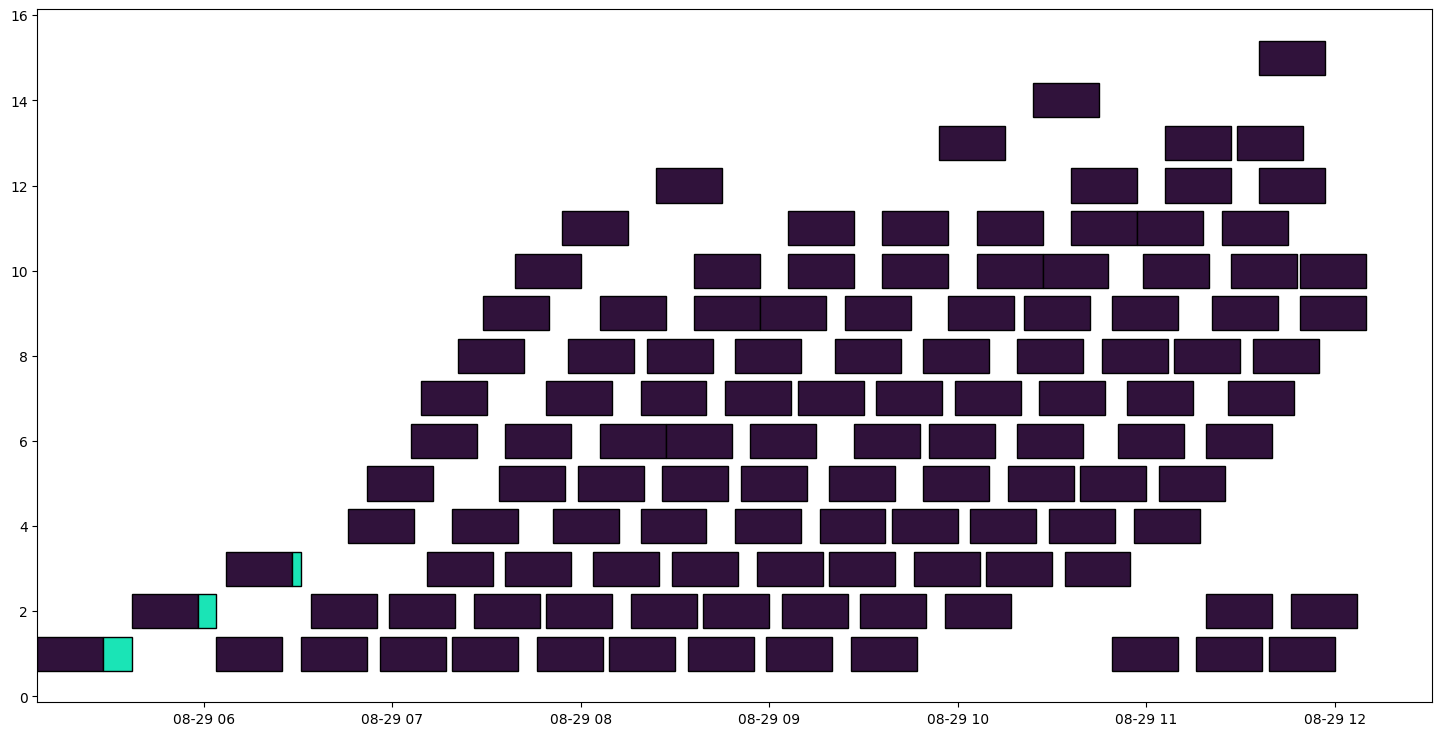

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd
import numpy as np

# Zorg ervoor dat df_adjusted de juiste kolommen bevat
# Veronderstel dat df_adjusted al is geladen met de juiste gegevens
# Bijvoorbeeld: df_adjusted = pd.read_excel('jouw_bestand.xlsx', engine='openpyxl')

# Converteer vertrek- en aankomsttijden naar datetime
df_with_idle['vertrek_datetime'] = pd.to_datetime(df_with_idle['vertrek_datetime'])
df_with_idle['aankomst_datetime'] = pd.to_datetime(df_with_idle['aankomst_datetime'])

# Voeg een nieuwe kolom toe voor activiteit
activities = df_with_idle['activiteit'].unique()
cmap = plt.colormaps.get_cmap('turbo')
colors = [cmap(i / len(activities)) for i in range(len(activities))]
color_dict = {activity: colors[i] for i, activity in enumerate(activities)}

# Maak het Gantt-diagram
fig, ax = plt.subplots(figsize=(18, 9))

# Loop door elke omloop en teken de activiteiten
for idx, row in df_with_idle.iterrows():
    ax.barh(row['Omloop'], 
            row['aankomst_datetime'] - row['vertrek_datetime'], 
            left=row['vertrek_datetime'], 
            color=color_dict[row['activiteit']],
            edgecolor='black')

# Format x-as voor tijd
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Format Y-as voor omloopnummers
ax.set_yticks(df_with_idle['Omloop'].unique())
ax.set_yticklabels(df_with_idle['Omloop'].unique())  # Zorg ervoor dat de labels correct zijn

# Maak een legenda
legend_elements = [Patch(facecolor=color_dict[activity], label=activity) for activity in activities]
ax.legend(handles=legend_elements, title="Activiteit", bbox_to_anchor=(1.05, 1), loc='upper left')

# Stel labels en titel in
ax.set_xlabel('Tijd')
ax.set_ylabel('Omloop nummer')
ax.set_title('Omloopplanning Gantt Chart')

# Pas de lay-out aan en sla de figuur op
plt.tight_layout()
plt.savefig('Omloopplanning_Gantt.png')

# Toon het diagram
plt.show()
